In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as inte

In [1032]:
def fix_plot(ax):
    ax.tick_params(which="minor", direction="in", length=3, width=1.3,)
    ax.tick_params(which="major", direction="in", length=6, width=1.3)
    ax.tick_params(which="minor", direction="in", length=3, width=1.3,)
    ax.tick_params(which="major", direction="in", length=6, width=1.3)
    plt.setp(ax.spines.values(), linewidth=1.3)
    plt.setp(ax.spines.values(), linewidth=1.3)

# Classic Harmonic Oscillator

## Harmonic oscillator class with direct integration

#### For direct integration, we use the potential $V(x) = \frac{1}{2} k x^2$, the distribution function $P(x) = \sqrt{\frac{k}{2 \pi k_B T}} exp(- \frac{\frac{1}{2}kx^2}{k_B T})$ and find the thermally averaged energy as $\braket{V(x)} = \int^\infty_{-\infty}{V(x)P(x)dx}$

In [1486]:
k_B = 8.617e-5 # eV/K
class Harmonic_Oscillator:
    def __init__(self, k, T, new_potential=False):
        self._new_potential = new_potential
        self._k = k
        self._T = T
        self._xmin = -10
        self._xmax = 10
        self._V_direct_inte = self.V_direct_integrate()
        self._V_direct_monte = None
        self._V_metro_monte = None
        self.samples = None
        

    @property
    def T(self):
        return self._T

    @property
    def V_direct_inte(self):
        return self._V_direct_inte

    @property
    def V_direct_monte(self):
        return self._V_direct_monte
    
    @V_direct_monte.setter
    def V_direct_monte(self, new_val):
        self._V_direct_monte = new_val

    @property
    def V_metro_monte(self):
        return self._V_metro_monte
    
    @V_metro_monte.setter
    def V_metro_monte(self, new_val):
        self._V_metro_monte = new_val

    def V(self, x): # Let's say that k is of units [eV][Å]^-2. Then the x axis is automatically Ångstrom, energy eV, since k_B is noted in eV/K
        if self._new_potential == False: return 1/2*self._k*x*x
        else:
            return np.cos(10*x) + x**2 + 1 #1.75*(1 - np.exp(-2*(x - 1)))**2
    
    def P(self, x):
        return np.sqrt(self._k/(2*np.pi*k_B*self._T))*np.exp(- (self.V(x))/(k_B * self._T))
    
    def V_times_P(self, x):
        return self.V(x)*self.P(x)
    
    def V_squared_times_P(self, x):
        return self.V(x)*self.V(x)*self.P(x)

    def V_direct_integrate(self):
        res = inte.quad(self.V_times_P, self._xmin, self._xmax)[0]
        return res
    
    def V_squared_direct_integrate(self):
        res = inte.quad(self.V_squared_times_P, self._xmin, self._xmax)[0]
        return res

    def plot_potential(self, ax, xlin, monteplot=False):
        ax.plot(xlin, self.V(xlin), label=f"k = {self._k}", color="lightcoral", alpha=0.85)
        #if monteplot == False:
        ax.bar(xlin, self.P(xlin), np.mean(np.diff(xlin)), edgecolor='k', color="indianred", alpha=0.7, label="direct integration")
        if monteplot:
            heights, bins = np.histogram(self.samples, bins=50 + int((self._T/300)), density=True)
            ax.bar(bins[:-1], heights, align="edge", width=np.mean(np.diff(bins)),edgecolor='k', color="skyblue", alpha=0.6, label="metropolis")
        title_string = ""

        if self._V_direct_inte != None: title_string += r"$V_{di} =$ " + f"{self._V_direct_inte:.3f} eV"
        if self._V_direct_monte != None: title_string += r",   $V_{dm} =$"  f"{self._V_direct_monte:.3f} eV"
        if self._V_metro_monte != None: title_string += r",   $V_{mm} =$"  f"{self._V_metro_monte:.3f} eV"

        ax.set_title(title_string, fontsize=14)
        ax.plot([xlin[0], xlin[-1]], [self._V_direct_inte, self._V_direct_inte], "--", color="wheat")
        ax.legend(loc="upper center")






## Monte Carlo Sampler Class

#### We draw random points $x_i$, drive them through an acceptance function that demands 0 $\leq RND \times Y(x_i) \leq P(x_i)$ until we have a desired number of sample points. Then we calculate the average potential energy with respect to this discrete set of points.

We define the constant distribution function $Y(x_i) = 1/Q$, which means that we can rewrite the acception criteria as:

$\leq RND \times 1 \leq Q P(x_i) = exp(- \frac{V(x)}{k_BT})$. (Since $P(x) = \frac{1}{Q} exp(- \frac{V(x)}{k_BT})$)

Then, we do not need to know the partition function in order to perform the Monte Carlo Sampling

Instead, we draw a sample of points corresponding to the same distribution, and can easily calculate an average energy, since we know the number of samples (thus avoiding the problem om normalizing the distribution function, which is the purpose of the partition function)

Furthermore, this choice of $Y(x)$ satisfies $Y(x) > P(x)$ for all $x$, since the potential is an even function, and the exponential $exp(- \frac{\frac{1}{2} k x^2}{k_BT}) < 1$ for all $x$.

In [1487]:
class Monte_Sampler:

    def __init__(self, N):
        self._xmin = -10
        self._xmax = 10
        self._no_of_samples = N

    def sample_xi(self):
        return (np.random.rand()-0.5)*2*self._xmax

    def acceptance(self, xi, V, T):
        return 0 <= np.random.rand() <= np.exp(-V(xi)/(k_B*T))
    
    def run(self, V, T):
        xis = np.zeros(shape=(self._no_of_samples))
        for i in range(self._no_of_samples):
            xi = self.sample_xi()
            while not self.acceptance(xi, V, T):
                xi = self.sample_xi()
            xis[i] = xi
        
        sum = 0
        for xi in xis:
            sum += V(xi)
        res = sum/self._no_of_samples
        return res

## Calculations

### Thermally averaged potentials with direct integration $V_i$ and Direct Monte Carlo Sampling $V_m$

In [1488]:
#Instantiate two harmonic oscillators
osc = Harmonic_Oscillator(3, 5000)
osc2 = Harmonic_Oscillator(6, 5000)

#Instantiate Monte Carlo Sampler and run it for each oscillator
mo = Monte_Sampler(40000)
V_monte1 = mo.run(osc.V, osc.T)
V_monte2 = mo.run(osc2.V, osc.T)

#Add the new results to the Oscillators
osc.V_direct_monte = V_monte1
osc2.V_direct_monte = V_monte2

### Heat Capacities from numerical differentiation

#### We use $C_V  = \frac{d \braket{V(x)}}{dT}$

In [1489]:
k_experiment = 6
T_final = 1000000
T_initial = 1000
Temps, dT = np.linspace(T_initial, T_final, 1000, retstep=True)

#Collect set of temperatures and corresponding thermally averaged energies
energies = []
for T in Temps:
    osci = Harmonic_Oscillator(k_experiment, T)
    energies.append(osci.V_direct_inte)

#Calculate gradients
grads = np.zeros(shape=(len(energies)))
for i in range(len(energies)-1):
    grad = (energies[i+1] - energies[i])/(Temps[i+1] - Temps[i])
    grads[i] = grad

### Heat Capacities from energy fluctuations

#### We use $C_V = \frac{\braket{V(x)^2} - \braket{V(x)}^2}{k_B T^2}$

In [1490]:

def C_V_fluc(temp):
    osci = Harmonic_Oscillator(k_experiment, temp)
    v_squared_mean = osci.V_squared_direct_integrate() # <V^2>
    v_mean_squared = osci.V_direct_inte*osci.V_direct_inte # <V>^2
    dispersion = v_squared_mean - v_mean_squared
    c_v = dispersion/(k_B*temp*temp)
    return c_v

C_V_flucs = np.array([])
for temp in Temps:
    C_V_flucs = np.append(C_V_flucs, C_V_fluc(temp))

## Results

### Thermally averaged potentials with direct integration $V_i$ and Direct Monte Carlo Sampling $V_m$

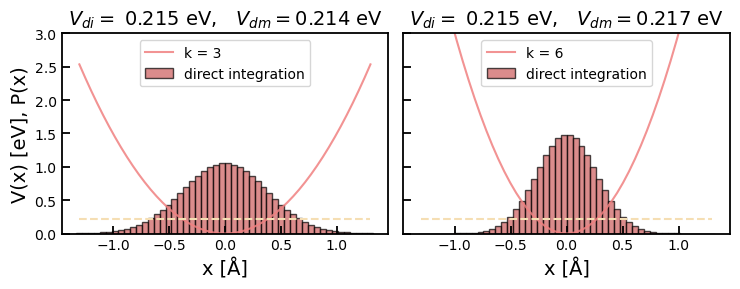

In [1491]:
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3), sharey=True)
ax[0].set_ylabel(f"V(x) [eV], P(x)", fontsize=14)
for axs in [0, 1]:
    fix_plot(ax[axs])
    ax[axs].set_xlabel(f"x [Å]", fontsize=14)
    ax[axs].set_ylim(0, 3)
xlin = np.linspace(-1.3, 1.3)

osc.plot_potential(ax[0], xlin)
osc2.plot_potential(ax[1], xlin)
fig.tight_layout()

### Heat Capacities from numerical differentiation


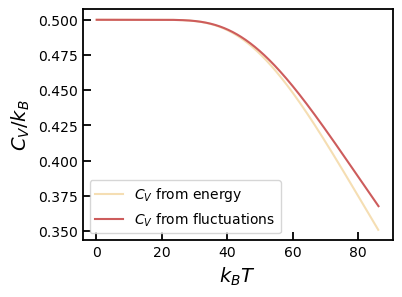

In [1492]:
fig, ax = plt.subplots(figsize=(4, 3))
fix_plot(ax)
ax.plot(Temps[:-1]*k_B, grads[:-1]/k_B, label=f"$C_V$ from energy", color="wheat")
ax.plot(Temps*k_B, C_V_flucs/k_B, label=f"$C_V$ from fluctuations", color="indianred")
ax.set_xlabel(f"$k_BT$", fontsize=14)
ax.set_ylabel(f"$C_V/k_B$", fontsize=14)
ax.legend()

The reason for this divergence is the decreasing legitimacy of the approximation that we may just integrate from some finite xmin to some finite xmax, rather than integrate over all space, as the temperature increases and the resulting probability distribution flattens, i.e., we are missing an increasing part of the tail of the distribution as the temperature rises, resulting in an underestimated heat capacity.

## Mentropolis Monte Carlo Sampling Class

#### With this method, we avoid calculating partition functions, since $P(x')/P(x) = exp(- \frac{V(x') - V(x)}{k_B T})$

##### We can construct the Metropolis Monte Carlo Sampling class as a subclass of the direct Monte Carlo Sampler, since it will contain some of the same information / methods. Then we just overwrite the things that need to be changed and add the things that need to be added.

In [1493]:
class Metropolis_Monte(Monte_Sampler):
    def __init__(self, N, x0):
        super().__init__(N)
        self._x = x0

    def acceptance(self, V, T, x, x_prime):
        prob = min([1, np.exp(- (V(x_prime))/(k_B*T))/np.exp(- (V(x))/(k_B*T))])
        number = np.random.rand()
        if number <= prob: return True
        return False

    def sample_xi(self, x, Delta, uniform):
        if uniform:
            return (self._xmax - self._xmin)*np.random.rand() + self._xmin
        else:
            dx = (np.random.normal())*Delta
            xi = x + dx
        return xi

    def run(self, V, T, Delta=0.1, uniform=False):
        xis = np.zeros(shape=(self._no_of_samples))
        for i in range(self._no_of_samples):
            xi = self.sample_xi(self._x, Delta=Delta, uniform=uniform)
            while not self.acceptance(V, T, self._x, xi):
                xi = self.sample_xi(self._x, Delta=Delta, uniform=uniform)
            xis[i] = xi
            self._x = xi
        
        sum = 0
        for xi in xis:
            sum += V(xi)
        res = sum/self._no_of_samples
        return res, xis


### Metropolis Monte Carlo Samlping Testing (vs. direct integration)

In [1494]:
#Instantiate Metropolis Monte Carlo Sampler and run it for each oscillator
metro_mo = Metropolis_Monte(40000, 0)
osc.V_metro_monte, osc.samples = metro_mo.run(osc.V, osc.T)
osc2.V_metro_monte, osc2.samples = metro_mo.run(osc2.V, osc.T)

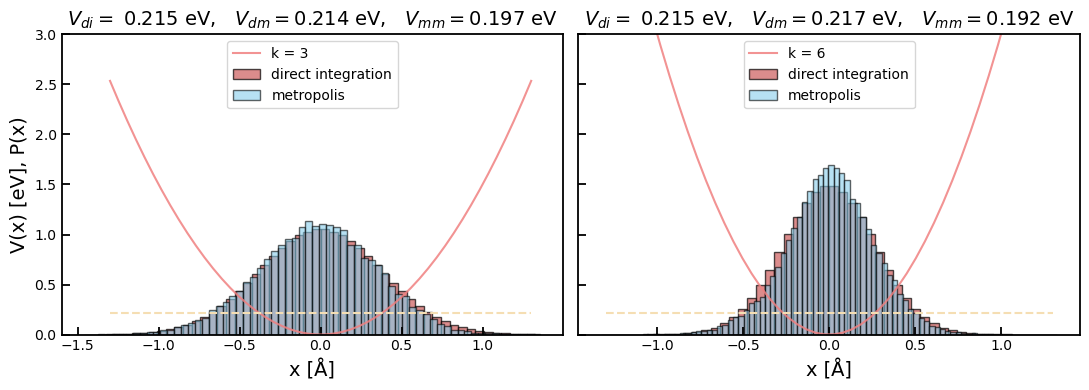

In [1495]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
ax[0].set_ylabel(f"V(x) [eV], P(x)", fontsize=14)
for axs in [0, 1]:
    fix_plot(ax[axs])
    ax[axs].set_xlabel(f"x [Å]", fontsize=14)
    ax[axs].set_ylim(0, 3)
xlin = np.linspace(-1.3, 1.3)

osc.plot_potential(ax[0], xlin, monteplot=True)
osc2.plot_potential(ax[1], xlin, monteplot=True)
fig.tight_layout()

### Metropolis Monte Carlo Sampling - Variyng sampling size

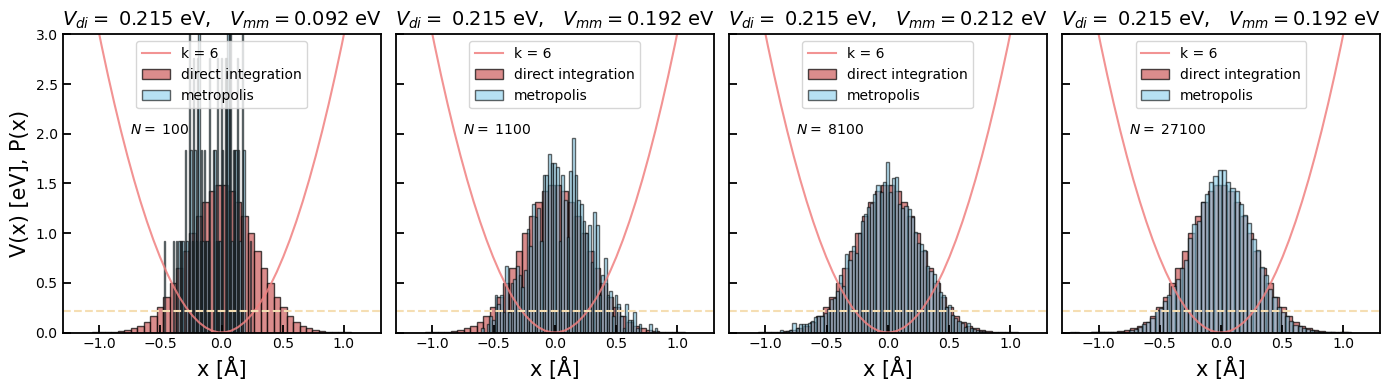

In [1496]:
def varied_N(uniform=False, new_potential=False, xlin=np.linspace(-1.3, 1.3), xlim=(xlin[0], xlin[-1]), n_loc=(-0.75, 2)):
    fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
    ax[0].set_ylabel(f"V(x) [eV], P(x)", fontsize=15)

    for n in range(4):
        fix_plot(ax[n])
        this_osc = Harmonic_Oscillator(6, 5000, new_potential=new_potential)
        this_N = n**3*1000 + 100
        this_metro = Metropolis_Monte(this_N, 0)
        this_osc.V_metro_monte, this_osc.samples = this_metro.run(this_osc.V, this_osc.T, uniform=uniform)
        this_osc.plot_potential(ax[n], xlin, monteplot=True)
        ax[n].text(n_loc[0], n_loc[1], f"$N = $ {this_N}", )
        ax[n].set_ylim(0, 3)
        ax[n].set_xlim(xlim[0], xlim[1])
        ax[n].set_xlabel(f"x [Å]", fontsize=15)
    fig.tight_layout()
varied_N()

### Metropolis Monte Carlo Sampling - Variying $\Delta$

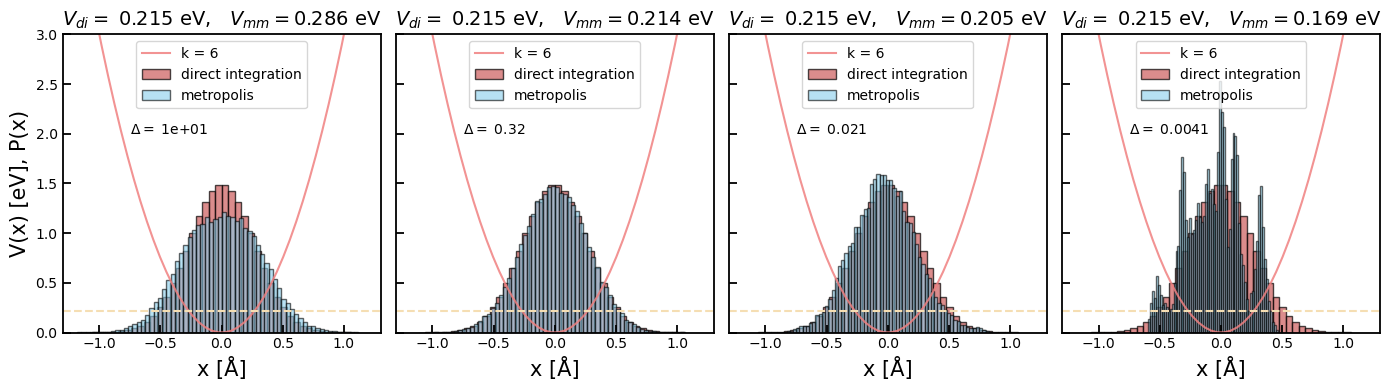

In [1497]:
def varied_Delta(uniform=False, new_potential=False, xlin = np.linspace(-1.3, 1.3), xlim=(xlin[0], xlin[-1]), n_loc=(-0.75, 2), this_N=50000):
    fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
    ax[0].set_ylabel(f"V(x) [eV], P(x)", fontsize=15)

    for n in range(4):
        fix_plot(ax[n])
        this_Delta = 10/(30*n**4+1)
        this_osc = Harmonic_Oscillator(6, 5000, new_potential=new_potential)
        this_metro = Metropolis_Monte(this_N, 0)
        this_osc.V_metro_monte, this_osc.samples = this_metro.run(this_osc.V, this_osc.T, Delta=this_Delta, uniform=uniform)
        this_osc.plot_potential(ax[n], xlin, monteplot=True)
        ax[n].text(n_loc[0], n_loc[1], f"$\Delta = $ {this_Delta:.2}", )
        ax[n].set_ylim(0, 3)
        ax[n].set_xlim(xlim[0], xlim[1])
        ax[n].set_xlabel(f"x [Å]", fontsize=15)
    fig.tight_layout()
varied_Delta()

### Uniform transitions

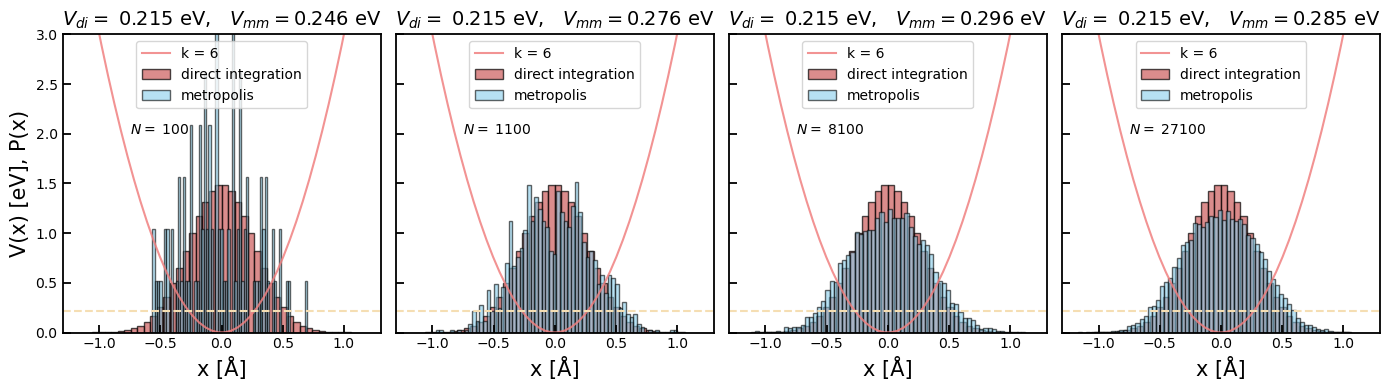

In [1498]:
varied_N(uniform=True)

### Interpretation:

#### It appears that using uniform transitions will consistently overestimate the thermally averaged energy, regardless of increasing the sample size

## Personal Potential

### Varying N

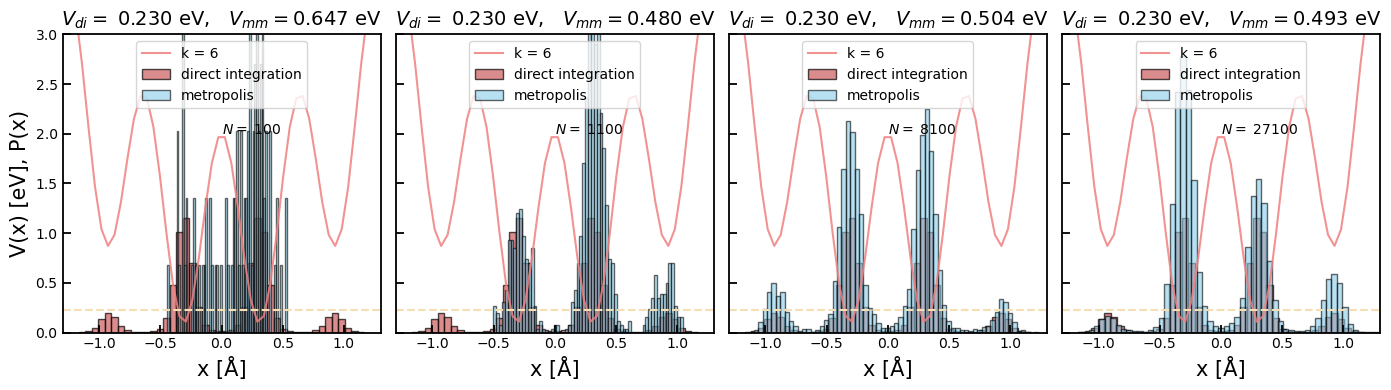

In [1499]:
varied_N(new_potential=True, xlin=np.linspace(-1.3, 1.3), xlim=(-1.3, 1.3), n_loc=(0, 2))

### Varying $\Delta$

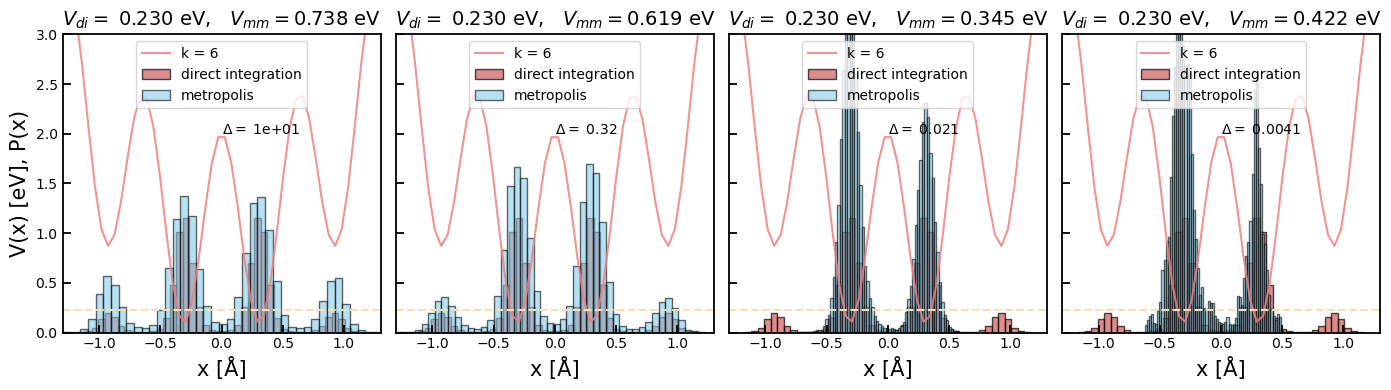

In [1500]:
varied_Delta(new_potential=True, xlin=np.linspace(-1.3, 1.3), xlim=(-1.3, 1.3), n_loc=(0, 2), this_N=50000)

### Uniform Distribution

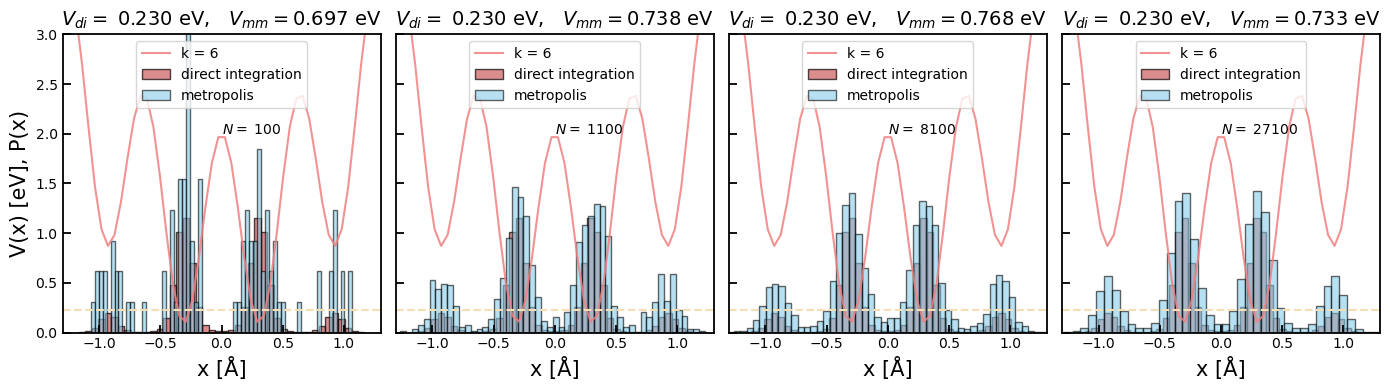

In [1501]:
varied_N(new_potential=True, xlin=np.linspace(-1.3, 1.3), xlim=(-1.3, 1.3), n_loc=(0, 2), uniform=True)

### Varying Temperature

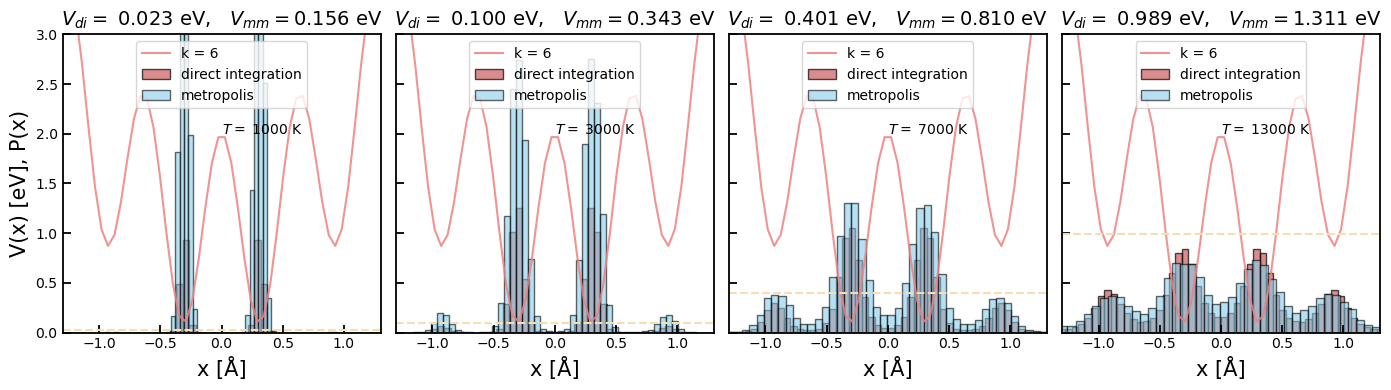

In [1502]:
def varied_T(uniform=False, new_potential=False, xlin = np.linspace(-1.3, 1.3), xlim=(xlin[0], xlin[-1]), n_loc=(-0.75, 2), this_N=50000, this_Delta=0.1):
    fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
    ax[0].set_ylabel(f"V(x) [eV], P(x)", fontsize=15)

    for n in range(4):
        fix_plot(ax[n])
        this_T = 1000*(n**2 + n + 1)
        this_osc = Harmonic_Oscillator(6, this_T, new_potential=new_potential)
        this_metro = Metropolis_Monte(this_N, 0)
        this_osc.V_metro_monte, this_osc.samples = this_metro.run(this_osc.V, this_osc.T, Delta=this_Delta, uniform=uniform)
        this_osc.plot_potential(ax[n], xlin, monteplot=True)
        ax[n].text(n_loc[0], n_loc[1], f"$T = $ {this_T} K", )
        ax[n].set_ylim(0, 3)
        ax[n].set_xlim(xlim[0], xlim[1])
        ax[n].set_xlabel(f"x [Å]", fontsize=15)
    fig.tight_layout()
varied_T(new_potential=True, xlin=np.linspace(-1.3, 1.3), xlim=(-1.3, 1.3), n_loc=(0, 2), this_N=30000, this_Delta=0.3)

### Remarks:

#### The discrepancies that we see, indicating that either "metropolis" or "direct integration" is not properly normalized, are indeed due to inproper normalization of the "direct integral" distribution. This is really just the partition function of a harmonic oscillator, multiplied with a boltzmann-factor corresponding to the new potential, i.e., the new partition function is not calculated for this new potential (instead, the old one is simply used), leading to error. This demonstrates precisely the advantage of the Monte Carlo Sampling methods - I can achieve a normalized distribution without calculating the partition function